# Loading important packages

In [11]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import string
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from pandas import DataFrame

# Data Preprocessing

In [3]:
# df1 = pd.read_csv('./datasets/2020-08-19.csv') '''not required for our project'''
df2 = pd.read_csv('./datasets/bgg-15m-reviews.csv')
# df3 = pd.read_csv('./datasets/games_detailed_info.csv') '''not required for our project''''''

## Dropping columns which are not required.

Use once

In [4]:
del df2['Unnamed: 0']
del df2['ID']
del df2['name']
del df2['user']

## Dropping rows with NaN values.

In [5]:
df = df2.dropna()

In [6]:
df.shape

(2995023, 2)

In [7]:
df['rating'].unique()

array([10.     ,  9.8    ,  9.5    , ...,  7.98525,  9.03333,  5.767  ])

In [9]:
decimals = pd.Series([0], index=['rating'])
df = df.round(decimals)

In [13]:
df['rating'].unique()

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.])

## Rounding up the ratings for better efficieny of the model

In [14]:
def rating_enhancement(rating):
    if rating == 10.0:
        return int(10)
    elif rating >=9.5 and rating <10:
        return int(10)
    elif rating <9.5 and rating >=9:
        return int(9)
    elif rating >=8.5 and rating <9:
        return int(9)
    elif rating <8.5 and rating >=8:
        return int(8)
    elif rating >=7.5 and rating <8:
        return int(8)
    elif rating <7.5 and rating >=7:
        return int(7)
    elif rating >=6.5 and rating <7:
        return int(7)
    elif rating <6.5 and rating >=6:
        return int(6)
    elif rating >=5.5 and rating <6:
        return int(6)
    elif rating <5.5 and rating >=5:
        return int(5)
    elif rating >=4.5 and rating <5:
        return int(5)
    elif rating <4.5 and rating >=4:
        return int(4)
    elif rating >=3.5 and rating <4:
        return int(4)
    elif rating <3.5 and rating >=3:
        return int(3)
    elif rating >=2.5 and rating <3:
        return int(3)
    elif rating <2.5 and rating >=2:
        return int(2)
    elif rating >=1.5 and rating <2:
        return int(2)
    elif rating <1.5 and rating >=1:
        return int(1)

In [15]:
df['rating'] = df['rating'].apply(rating_enhancement)
df['rating'] = df['rating'].apply(rating_enhancement)

In [16]:
df = df.dropna()

In [17]:
df['rating'].unique()

array([10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.])

In [18]:
df.shape

(2995023, 2)

In [19]:
df

,rating,comment
1,10.0,Hands down my favorite new game of BGG CON 200...
2,10.0,I tend to either love or easily tire of co-op ...
4,10.0,This is an amazing co-op game. I play mostly ...
5,10.0,Hey! I can finally rate this game I've been pl...
8,10.0,Love it- great fun with my son. 2 plays so far...
...,...,...
15823242,10.0,KS Collector's Bundle with a friend of mine
15823247,10.0,Belekokio Gerumo...
15823253,10.0,Excelente!! lo mejor que probé.
15823264,8.0,Turn based preview looks very promising. The g...


Storing in a pickle object as dataset is too large

In [20]:
 with open('./datasets/pickle_data/dataset_preclean.pkl', 'wb') as pickle_file:
        pickle.dump(df, pickle_file)

Loading the pickle object

In [3]:
with open('./datasets/pickle_data/dataset_preclean.pkl', 'rb') as pickle_file:
        df = pickle.load(pickle_file)

## Cleaning the comments

In [12]:
def clean_comments(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)

    text = re.sub(r"[0-9]+", ' ', text)
    text = re.sub(r"-", ' ', text)
    
    
    text = text.strip().lower()
    

    default_stop_words = set(stopwords.words('english'))
    default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
    stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                           'would','must',"'ve","'ll",'may'})

    word_list = word_tokenize(text)
    filtered_list = [w for w in word_list if not w in stop_words]
    text = ' '.join(filtered_list)
    
    text = re.sub(r"'", ' ', text)
    
   
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    

    text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)
    
    text = ''.join(text)

    return text

In [23]:
%%time
df['clean_comment'] = df['comment'].apply(clean_comments)

Wall time: 30min 23s


In [24]:
freq_train1 = pd.Series(' '.join(df['clean_comment']).split()).value_counts()
less_five_freq_train1 = freq_train1[(freq_train1 <10)]
print('Words occuring less than 5 are: ')
print('')
print(less_five_freq_train1)

Words occuring less than 5 are: 

aparatoso      9
fólia          9
usen           9
jinks          9
kedv           9
              ..
narodowe       1
rusht          1
torkollhat     1
inflaba        1
selebrarion    1
Length: 491238, dtype: int64


In [25]:
%%time
df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train1))

Wall time: 58.2 s


In [13]:
def NormalizeWithPOS(text):
    # Lemmatization & Stemming according to POS tagging

    word_list = word_tokenize(text)
    rev = []
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer() 
    for word, tag in pos_tag(word_list):
        if tag.startswith('J'):
            w = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemmatizer.lemmatize(word, pos='r')
        else:
            w = word
        w = stemmer.stem(w)
        rev.append(w)
    review = ' '.join(rev)
    return review

In [30]:
%%time
df['clean_comment'] = df['clean_comment'].apply(NormalizeWithPOS)

Wall time: 1h 51min 2s


In [6]:
df

,rating,comment
1,10.0,Hands down my favorite new game of BGG CON 200...
2,10.0,I tend to either love or easily tire of co-op ...
4,10.0,This is an amazing co-op game. I play mostly ...
5,10.0,Hey! I can finally rate this game I've been pl...
8,10.0,Love it- great fun with my son. 2 plays so far...
...,...,...
15823242,10.0,KS Collector's Bundle with a friend of mine
15823247,10.0,Belekokio Gerumo...
15823253,10.0,Excelente!! lo mejor que probé.
15823264,8.0,Turn based preview looks very promising. The g...


Pickling the cleaned data

In [32]:
with open('./datasets/pickle_data/dataset.pkl', 'wb') as pickle_file:
        pickle.dump(df, pickle_file)

Load the cleaned data object

In [14]:
with open('./datasets/pickle_data/dataset.pkl', 'rb') as pickle_file:
        dataset = pickle.load(pickle_file)

In [15]:
rating_num_set = {}
for rating in (10-dataset['rating'].unique()):
    new_comment_rating = dataset.loc[dataset['rating'] >= (rating - 0.5)]
    new_comment_rating = new_comment_rating.loc[new_comment_rating['rating'] <= (rating + 0.5)]
    new_comment_rating = new_comment_rating.sample(frac = 1).reset_index(drop = True)
    rating_num_set[rating] = new_comment_rating

for rating in rating_num_set:
    print("rating: ", rating, "rating num:",  len(rating_num_set[rating]))

rating:  0.0 rating num: 9
rating:  1.0 rating num: 23513
rating:  2.0 rating num: 45046
rating:  3.0 rating num: 79101
rating:  4.0 rating num: 151068
rating:  5.0 rating num: 242647
rating:  6.0 rating num: 587568
rating:  7.0 rating num: 650409
rating:  8.0 rating num: 751962
rating:  9.0 rating num: 279371
rating:  10.0 rating num: 184329


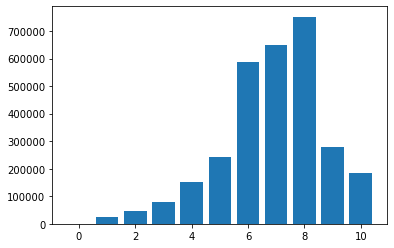

In [16]:
rating_list = []
for rating in rating_num_set: 
    rating_list.append(len(rating_num_set[rating]))
plt.bar(range(len(rating_list)), rating_list)
plt.show()

In [17]:
print("A review example of dataset before cleaning:")
print(dataset.iloc[0]['comment'], end='\n\n')

print("clean_text:")
print(dataset.iloc[0]['clean_comment'], end="\n\n")

A review example of dataset before cleaning:
Hands down my favorite new game of BGG CON 2007.  We played it 5 times in a row -- it's just that good.  Too bad Pandemic won't be in stores until January of 2008.  If you like pure coöp games (Lord of the Rings, Feurio, etc.), this should be right up your alley.  Having 5 roles to choose from gives the game some extra variability.  Also, once you get good you can ramp up the difficulty by adding more Epidemic cards.  9 -> 10

clean_text:
hand favorit new game bgg con play time row good too bad pandem not store januari like pure coöp game lord ring feurio etc right alley role choos give game extra variabl also get good ramp difficulti add epidem card



# Train and Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(dataset['clean_comment'], dataset['rating'], test_size=0.25, random_state=42)

In [102]:
X_train.index = [x for x in range(1, len(X_train.values)+1)]
X_test.index = [x for x in range(1, len(X_test.values)+1)]
y_train.index = [x for x in range(1, len(y_train.values)+1)]
y_test.index = [x for x in range(1, len(y_test.values)+1)]

In [103]:
with open('./datasets/pickle_data/X_train.pkl', 'wb') as pickle_file:
    pickle.dump(X_train, pickle_file)
with open('./datasets/pickle_data/X_test.pkl', 'wb') as pickle_file:
    pickle.dump(X_test, pickle_file)
with open('./datasets/pickle_data/y_train.pkl', 'wb') as pickle_file:
    pickle.dump(y_train, pickle_file)
with open('./datasets/pickle_data/y_test.pkl', 'wb') as pickle_file:
    pickle.dump(y_test, pickle_file)

In [18]:
with open('./datasets/pickle_data/X_train.pkl', 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)
with open('./datasets/pickle_data/X_test.pkl', 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)
with open('./datasets/pickle_data/y_train.pkl', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)
with open('./datasets/pickle_data/y_test.pkl', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)

# Create Bag of Words

In [19]:
vectorizer = CountVectorizer(stop_words='english')

In [20]:
%%time

training_features = vectorizer.fit_transform(X_train)
testing_features = vectorizer.transform(X_test)

Wall time: 58.2 s


In [21]:
with open('./datasets/pickle_data/vectorizer.pkl', 'wb') as pickle_file:
    pickle.dump(vectorizer, pickle_file)

Pickling the bow object

In [22]:
with open('./datasets/pickle_data/training_features.pkl', 'wb') as pickle_file:
    pickle.dump(training_features, pickle_file)
with open('./datasets/pickle_data/testing_features.pkl', 'wb') as pickle_file:
    pickle.dump(testing_features, pickle_file)

In [23]:
with open('./datasets/pickle_data/training_features.pkl', 'rb') as pickle_file:
    training_features = pickle.load(pickle_file)
with open('./datasets/pickle_data/testing_features.pkl', 'rb') as pickle_file:
    testing_features = pickle.load(pickle_file)

In [24]:
training_features.shape

(2246267, 50737)

In [25]:
testing_features.shape

(748756, 50737)

# Multinomial Naive Bayes

# Model creation

In [26]:
model = MultinomialNB()

In [27]:
%%time

model.fit(training_features, y_train)

Wall time: 1.13 s


MultinomialNB()

In [28]:
predict_total = model.predict(testing_features)

In [29]:
predict_total

array([ 6.,  7.,  8., ...,  4.,  6., 10.])

In [30]:
y_test

1         8.0
2         8.0
3         6.0
4         5.0
5         5.0
         ... 
748752    3.0
748753    8.0
748754    5.0
748755    7.0
748756    8.0
Name: rating, Length: 748756, dtype: float64

# Hyperparameter Tuning

# Choosing mean squared error as my accuracy metric.

In [31]:
print(model.get_params())

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


In [32]:
alpha = np.linspace(0,1,100)

In [33]:
random_grid = {'alpha': alpha,
              'fit_prior': [True,False]}
print(random_grid)

{'alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.7373737

In [34]:
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [35]:
model_random.fit(training_features, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222,...
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'fit_prior': [True, False]},
                   random_state=42, verbose=2)

In [36]:
model_random.best_estimator_

MultinomialNB(alpha=0.9797979797979799)

In [37]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    MSE = mean_squared_error(test_labels,predictions)
    accuracy = accuracy_score(test_labels,predictions)*100
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MSE = {:0.2f}.'.format(MSE))
    
    return accuracy

In [50]:
base_model = MultinomialNB(alpha = 0.5)
base_model.fit(training_features, y_train)
base_accuracy = evaluate(base_model, testing_features, y_test)

Model Performance
Average Error: 1.2601 degrees.
Accuracy = 30.50%.
MSE = 3.30.


In [39]:
best_random = model_random.best_estimator_
random_accuracy = evaluate(best_random, testing_features, y_test)

Model Performance
Average Error: 1.2516 degrees.
Accuracy = 30.64%.
MSE = 3.26.


In [45]:
meanSquaredError1 = []
hyper_cond1 = []
alpha = np.linspace(0,1,100)
for i in alpha:
    nb_model = MultinomialNB(alpha = i)
    nb_model.fit(training_features, y_train)
    predictions = nb_model.predict(testing_features)
    MSE = mean_squared_error(y_test,predictions)
    meanSquaredError1.append(MSE)
    hyper_cond1.append(''+str(i))

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


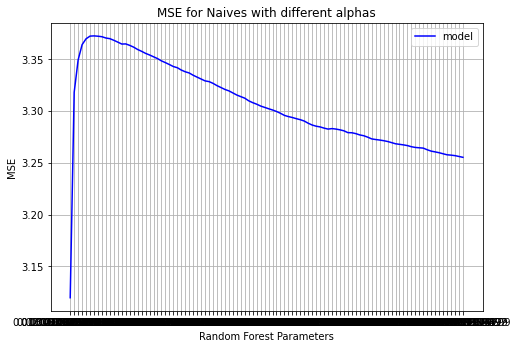

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(hyper_cond1, meanSquaredError1, color = 'b', label ='model')
ax.set_ylabel('MSE')
ax.set_xlabel('Random Forest Parameters')
ax.set_title('MSE for Naives with different alphas')
# ax.set_xticks(random_forest)
# plt.ylim((0,100))
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

# From the above we can coclude that aplha value of 0 gives me the least mean squared error.

# Model post Hyperparameter tuning

In [52]:
final_model_multinomial = MultinomialNB(alpha = 0)

In [53]:
%%time
final_model_multinomial.fit(training_features, y_train)

Wall time: 1.17 s


C:\Users\jonat\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


MultinomialNB(alpha=0)

In [54]:
predict_total = final_model_multinomial.predict(testing_features)

In [55]:
mean_squared_error(y_test,predict_total)

3.119694533332621

In [56]:
with open('./datasets/pickle_data/final_model_multinomial.pkl', 'wb') as pickle_file:
    pickle.dump(final_model_multinomial, pickle_file)

# User Input and model predictions

In [28]:
Input = input('Please enter a review: ')

Please enter a review: worst bad useless hated


In [29]:
%%time

Input = [Input]
input_df = DataFrame(Input,columns=['comment'])
input_df['clean_comment'] = input_df['comment'].apply(clean_comments)
input_df['clean_comment'] = input_df['clean_comment'].apply(NormalizeWithPOS)
input_testing_features = vectorizer.transform(input_df['clean_comment'])
predict = model.predict(input_testing_features)

Wall time: 1.48 s


In [30]:
predict[0]

1.0